# PCG 自洽场 (SCF) 求解流程概述
- 统一通过 `%run` 载入 `basis_func_with_kinetic.ipynb`、`Hartree.ipynb`、`Vps_lc.ipynb`、`Vps_nl.ipynb`、`Vex.ipynb` 中已经实现的平面波基组、Hartree/赝势/交换能模块。
- 在 K 空间使用平面波基展开波函数，并通过 K 空间势矩阵（局域与非局域赝势）以及由实时密度计算得到的 Hartree 与交换-相关势构造 KS Hamiltonian。
- 以 `generate_G_vectors` 返回的平面波为初始波函数，采用预条件共轭梯度 (PCG) 迭代求解 KS 方程最低本征态，同时迭代密度以实现 SCF。

Crystal: Al (FCC), a = 4.05 Å
Ecut = 300.0 eV -> 11.02480 Hartree
Number of plane waves (Gamma): 181
First 8 G coefficients: [(0, 0, 0), (1, 1, 1), (1, 0, 0), (0, 1, 0), (0, 0, 1), (0, 0, -1), (-1, 0, 0), (-1, -1, -1)]
First 8 kinetic energies (Hartree): [0.       1.010982 1.010982 1.010982 1.010982 1.010982 1.010982 1.010982]
Crystal: Al (FCC), a = 4.05 Å
Ecut = 300.0 eV -> 11.02480 Hartree
Number of plane waves (Gamma): 181
First 8 G coefficients: [(0, 0, 0), (1, 1, 1), (1, 0, 0), (0, 1, 0), (0, 0, 1), (0, 0, -1), (-1, 0, 0), (-1, -1, -1)]
First 8 kinetic energies (Hartree): [0.       1.010982 1.010982 1.010982 1.010982 1.010982 1.010982 1.010982]
Cell volume (bohr^3): 112.073152
Hartree energy (Hartree): 0.01052706
Hartree energy (eV): 0.286456 eV
Largest contrib #1: |n(G)|^2/|G|^2 = 1.486583e-02, |G| = 4.443617e-02
Largest contrib #2: |n(G)|^2/|G|^2 = 1.486583e-02, |G| = 4.443617e-02
Largest contrib #3: |n(G)|^2/|G|^2 = 1.486583e-02, |G| = 4.443617e-02
Largest contrib #4: |n(G)|^2/

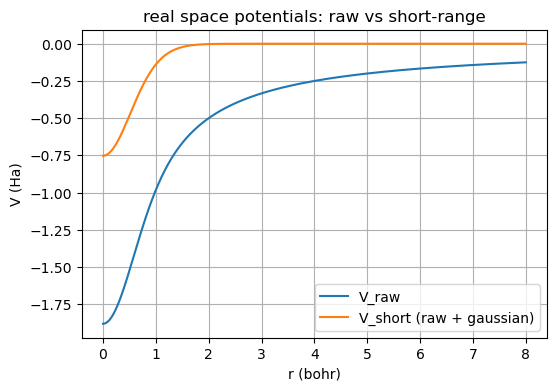

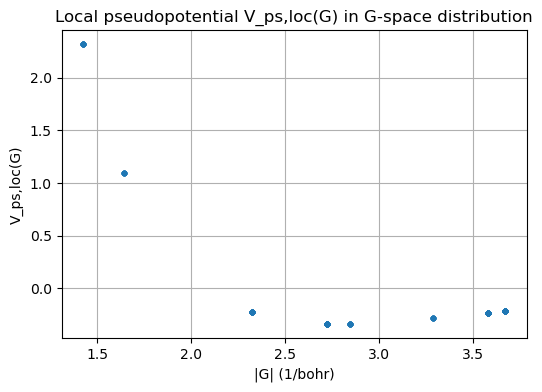

Crystal: Al (FCC), a = 4.05 Å
Ecut = 300.0 eV -> 11.02480 Hartree
Number of plane waves (Gamma): 181
First 8 G coefficients: [(0, 0, 0), (1, 1, 1), (1, 0, 0), (0, 1, 0), (0, 0, 1), (0, 0, -1), (-1, 0, 0), (-1, -1, -1)]
First 8 kinetic energies (Hartree): [0.       1.010982 1.010982 1.010982 1.010982 1.010982 1.010982 1.010982]
Crystal: Al (FCC), a = 4.05 Å
Ecut = 300.0 eV -> 11.02480 Hartree
Number of plane waves (Gamma): 181
First 8 G coefficients: [(0, 0, 0), (1, 1, 1), (1, 0, 0), (0, 1, 0), (0, 0, 1), (0, 0, -1), (-1, 0, 0), (-1, -1, -1)]
First 8 kinetic energies (Hartree): [0.       1.010982 1.010982 1.010982 1.010982 1.010982 1.010982 1.010982]
Crystal: Al (FCC), a = 4.05 Å
Ecut = 300.0 eV -> 11.02480 Hartree
Number of plane waves (Gamma): 181
First 8 G coefficients: [(0, 0, 0), (1, 1, 1), (1, 0, 0), (0, 1, 0), (0, 0, 1), (0, 0, -1), (-1, 0, 0), (-1, -1, -1)]
First 8 kinetic energies (Hartree): [0.       1.010982 1.010982 1.010982 1.010982 1.010982 1.010982 1.010982]
Cell volume (

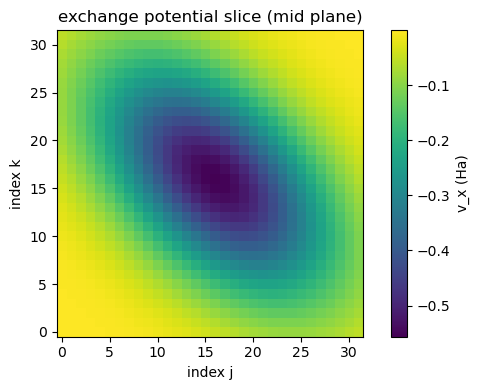

首个 G=0 分量 (v_x(G=0)) = -0.11686998356998642


In [205]:
%run basis_func_with_kinetic.ipynb
%run Hartree.ipynb
%run Vps_lc.ipynb
%run Vps_nl.ipynb
%run Vex.ipynb

import numpy as np
from dataclasses import dataclass
from typing import Dict, Tuple

np.set_printoptions(precision=6, suppress=True)

In [206]:
TOL = 1e-8

@dataclass
class PlaneWaveBasis:
    a_vecs: np.ndarray
    b_vecs: np.ndarray
    Omega: float
    Gs: np.ndarray
    energies: np.ndarray
    coeffs_int: list
    kvec: np.ndarray
    Nk: int
    r_grid: np.ndarray
    r_points: np.ndarray
    dV: float
    pw_matrix: np.ndarray

def build_plane_wave_basis(a0=4.05, Ecut_eV=80.0, Nk=16, kvec=None):
    """结合 `generate_G_vectors` 构造平面波基，并准备实空间 FFT 网格。"""
    a_vecs = primitive_fcc(a0)
    b_vecs, Omega = reciprocal_vectors(a_vecs)
    Gs, coeffs, energies = generate_G_vectors(b_vecs, Ecut_eV, kvec=kvec)
    if len(Gs) == 0:
        raise RuntimeError('未找到满足截断的 G 向量，请提高 Ecut_eV。')
    if kvec is None:
        kvec = np.zeros(3)

    us = np.arange(Nk) / Nk
    U, V, W = np.meshgrid(us, us, us, indexing='ij')
    r = (U[...,None] * a_vecs[0] + V[...,None] * a_vecs[1] + W[...,None] * a_vecs[2])
    r_points = r.reshape(-1, 3)
    dV = Omega / (Nk**3)

    k_plus_G = Gs + kvec
    phase = r_points @ k_plus_G.T
    pw_matrix = np.exp(1j * phase) / np.sqrt(Omega)

    return PlaneWaveBasis(
        a_vecs=a_vecs,
        b_vecs=b_vecs,
        Omega=Omega,
        Gs=Gs,
        energies=energies,
        coeffs_int=coeffs,
        kvec=np.array(kvec, dtype=float),
        Nk=Nk,
        r_grid=r,
        r_points=r_points,
        dV=dV,
        pw_matrix=pw_matrix,
    )

def coeffs_to_real(psi_coeffs: np.ndarray, basis: PlaneWaveBasis) -> np.ndarray:
    psi_flat = basis.pw_matrix @ psi_coeffs
    return psi_flat.reshape((basis.Nk, basis.Nk, basis.Nk))

def real_to_coeffs(psi_r: np.ndarray, basis: PlaneWaveBasis) -> np.ndarray:
    psi_flat = psi_r.reshape(-1)
    return basis.pw_matrix.conj().T @ (psi_flat * basis.dV)

def normalize_state(psi_coeffs: np.ndarray) -> np.ndarray:
    norm = np.linalg.norm(psi_coeffs)
    if norm < 1e-14:
        raise RuntimeError('波函数范数过小。')
    return psi_coeffs / norm

def project_out_locked(vec: np.ndarray, locked_states) -> np.ndarray:
    """将向量在已知本征态张成的子空间上投影并移除对应分量。"""
    if not locked_states:
        return vec
    result = vec.copy()
    for locked in locked_states:
        result -= np.vdot(locked, result) * locked
    return result

def orthonormalize_against(vec: np.ndarray, locked_states) -> np.ndarray:
    """相对于已收敛态做 Gram-Schmidt，并返回单位化向量。"""
    projected = project_out_locked(vec, locked_states)
    return normalize_state(projected)

In [207]:
def compute_density(psi_coeffs: np.ndarray, basis: PlaneWaveBasis, nelec: float = 1.0) -> np.ndarray:
    psi_r = coeffs_to_real(psi_coeffs, basis)
    rho = np.abs(psi_r)**2
    integral = np.sum(rho) * basis.dV
    if integral < 1e-8:
        raise RuntimeError('密度积分为 0。')
    rho *= nelec / integral
    return rho

def fft_density(rho: np.ndarray) -> np.ndarray:
    rho_G = np.fft.fftn(rho) / rho.size
    return rho_G

def build_G_grid(basis: PlaneWaveBasis) -> np.ndarray:
    Nk = basis.Nk
    freq = np.fft.fftfreq(Nk) * Nk
    mx, my, mz = np.meshgrid(freq, freq, freq, indexing='ij')
    Ggrid = (mx[...,None] * basis.b_vecs[0] + my[...,None] * basis.b_vecs[1] + mz[...,None] * basis.b_vecs[2]) / Nk
    return Ggrid

def hartree_potential_from_density(rho: np.ndarray, basis: PlaneWaveBasis) -> Tuple[np.ndarray, np.ndarray]:
    rho_G = fft_density(rho)
    Ggrid = build_G_grid(basis)
    norms = np.linalg.norm(Ggrid, axis=-1)
    vH_G = np.zeros_like(rho_G, dtype=complex)
    mask = norms > 1e-10
    vH_G[mask] = 4.0 * np.pi * rho_G[mask] / (norms[mask]**2)
    vH_G[~mask] = 0.0
    vH_r = np.fft.ifftn(vH_G * rho.size).real
    return vH_r, vH_G

def lda_exchange_correlation(rho: np.ndarray):
    eps_x, v_x = lda_exchange_potential(rho)
    return eps_x, v_x

In [208]:
def vector_key(vec: np.ndarray) -> Tuple[int, int, int]:
    scaled = np.round(vec / TOL).astype(int)
    return tuple(scaled.tolist())

def build_local_potential_dict(basis: PlaneWaveBasis, Ecut_eV: float, Z=1.0, r_c=0.6, r_gau=1.0) -> Dict[Tuple[int,int,int], float]:
    Gs_loc, Vloc = Vps_loc_total_on_Gvectors(
        basis.b_vecs,
        Ecut_eV,
        Z=Z,
        r_c=r_c,
        r_gau=r_gau,
        Nr=1200,
    )
    vdict = {}
    for vec, val in zip(Gs_loc, Vloc):
        vdict[vector_key(vec)] = val
    return vdict

def apply_local_potential(psi_coeffs: np.ndarray, basis: PlaneWaveBasis, vdict: Dict[Tuple[int,int,int], float]) -> np.ndarray:
    result = np.zeros_like(psi_coeffs, dtype=complex)
    for i, Gi in enumerate(basis.Gs):
        acc = 0.0j
        for j, Gj in enumerate(basis.Gs):
            diff_key = vector_key(Gi - Gj)
            Vij = vdict.get(diff_key)
            if Vij is None:
                continue
            acc += Vij * psi_coeffs[j]
        result[i] = acc
    return result

def build_nonlocal_matrix(basis: PlaneWaveBasis, projectors, atom_positions, Ecut_eV: float) -> np.ndarray:
    _, Vnl = nonlocal_pseudopotential_matrix(
        basis.a_vecs,
        atom_positions=atom_positions,
        projectors=projectors,
        Ecut_eV=Ecut_eV,
        kvec=basis.kvec,
        Gvecs_override=basis.Gs,
    )
    return Vnl

In [209]:
def apply_real_space_potential(psi_coeffs: np.ndarray, basis: PlaneWaveBasis, v_r: np.ndarray) -> np.ndarray:
    psi_r = coeffs_to_real(psi_coeffs, basis)
    vpsi_r = v_r * psi_r
    return real_to_coeffs(vpsi_r, basis)

def apply_hamiltonian(
    psi_coeffs: np.ndarray,
    basis: PlaneWaveBasis,
    vdict,
    v_r: np.ndarray,
    Vnl: np.ndarray,
    kinetic_shift: float = 0.0,
) -> np.ndarray:
    hpsi = basis.energies * psi_coeffs
    if kinetic_shift != 0.0:
        hpsi += kinetic_shift * psi_coeffs
    hpsi += apply_local_potential(psi_coeffs, basis, vdict)
    hpsi += apply_real_space_potential(psi_coeffs, basis, v_r)
    hpsi += Vnl @ psi_coeffs
    return hpsi

def build_preconditioner(basis: PlaneWaveBasis, energy_shift: float = 1.0) -> np.ndarray:
    diag = basis.energies + energy_shift
    diag = np.where(diag < 1e-3, 1e-3, diag)
    return 1.0 / diag

In [210]:
def pcg_ground_state(
    psi0: np.ndarray,
    basis: PlaneWaveBasis,
    vdict,
    v_r: np.ndarray,
    Vnl: np.ndarray,
    precond: np.ndarray,
    max_iter: int = 50,
    tol: float = 1e-8,
    locked_states=None,
 ) -> Tuple[np.ndarray, float, dict]:
    if locked_states is None:
        locked_states = []
    psi = orthonormalize_against(psi0.copy(), locked_states)
    history = {'eigs': [], 'res_norm': []}
    p = None
    z_prev = None
    residual_prev = None
    for _ in range(max_iter):
        hpsi = apply_hamiltonian(psi, basis, vdict, v_r, Vnl)
        eig = np.real(np.vdot(psi, hpsi))
        residual = hpsi - eig * psi
        residual = project_out_locked(residual, locked_states)
        res_norm = np.linalg.norm(residual)
        history['eigs'].append(eig)
        history['res_norm'].append(res_norm)
        if res_norm < tol:
            break
        z = project_out_locked(residual * precond, locked_states)
        if z_prev is None:
            p = -z
        else:
            denom = np.vdot(z_prev, residual_prev).real
            denom = denom if abs(denom) > 1e-14 else 1e-14
            beta = np.vdot(z, residual).real / denom
            p = -z + beta * p
        p = project_out_locked(p, locked_states)
        Hp = apply_hamiltonian(p, basis, vdict, v_r, Vnl)
        denom = np.vdot(p, Hp).real
        if abs(denom) < 1e-14:
            break
        alpha = np.vdot(residual, p).real / denom
        psi = psi + alpha * p
        psi = project_out_locked(psi, locked_states)
        psi = normalize_state(psi)
        z_prev = z
        residual_prev = residual
    if not history['eigs']:
        hpsi = apply_hamiltonian(psi, basis, vdict, v_r, Vnl)
        eig = np.real(np.vdot(psi, hpsi))
        history['eigs'].append(eig)
        history['res_norm'].append(0.0)
    return psi, history['eigs'][-1], history



In [211]:
def run_scf(
    a0=4.05,
    Ecut_eV=120.0,
    Nk=32,
    mix=0.3,
    max_scf=30,
    kvec=None,
    Z=3.0,
    r_c=0.6,
    r_gau=1.0,
    projectors=None,
    nelec=3.0,
    verbose=True,
) -> dict:
    basis = build_plane_wave_basis(a0=a0, Ecut_eV=Ecut_eV, Nk=Nk, kvec=kvec)
    if projectors is None:
        projectors = [
            GaussianProjectorChannel(l=0, D_l=-0.5, r_cut=1.0),
            GaussianProjectorChannel(l=1, D_l=-0.1, r_cut=1.2),
        ]
    atom_positions = [np.zeros(3)]
    Vnl = build_nonlocal_matrix(basis, projectors, atom_positions, Ecut_eV)
    vdict = build_local_potential_dict(basis, Ecut_eV, Z=Z, r_c=r_c, r_gau=r_gau)
    precond = build_preconditioner(basis)

    rng = np.random.default_rng(0)
    psi = normalize_state(rng.normal(size=len(basis.Gs)) + 1j * rng.normal(size=len(basis.Gs)))

    rho = compute_density(psi, basis, nelec=nelec)
    results = {'eig_history': [], 'rho_history': []}

    for scf_iter in range(1, max_scf + 1):
        vH_r, vH_G = hartree_potential_from_density(rho, basis)
        eps_x, v_x = lda_exchange_correlation(rho)
        v_total_r = vH_r + v_x

        psi, eig, pcg_hist = pcg_ground_state(psi, basis, vdict, v_total_r, Vnl, precond)
        rho_new = compute_density(psi, basis, nelec=nelec)
        rho = mix * rho_new + (1 - mix) * rho

        results['eig_history'].append(eig)
        results['rho_history'].append(rho.copy())
        if verbose:
            print(f'SCF iter {scf_iter}: eig = {eig:.6f} Ha, residual = {pcg_hist["res_norm"][-1]:.3e}')
            for it, (e_pc, r_pc) in enumerate(zip(pcg_hist['eigs'], pcg_hist['res_norm'])):
                if it % 10 == 0 or it == len(pcg_hist['eigs'])-1:
                    print(f"   PCG {it:2d}: eig = {e_pc:.6f}, res = {r_pc:.3e}")

    rho_final = rho
    vH_r, _ = hartree_potential_from_density(rho_final, basis)
    eps_x, v_x = lda_exchange_correlation(rho_final)
    v_total_r = vH_r + v_x

    psi_r = coeffs_to_real(psi, basis)
    E_kin = np.real(np.vdot(psi, basis.energies * psi))
    E_loc = np.real(np.vdot(psi, apply_local_potential(psi, basis, vdict)))
    E_nl = np.real(np.vdot(psi, Vnl @ psi))
    rho_G = fft_density(rho_final)
    Ggrid = build_G_grid(basis)
    E_H = compute_hartree_energy_from_nG(rho_G, Ggrid, basis.Omega)
    E_x = np.sum(eps_x * rho_final) * basis.dV
    E_tot = E_kin + E_loc + E_nl + E_H + E_x

    return {
        'psi_coeffs': psi,
        'psi_real': psi_r,
        'rho': rho_final,
        'basis': basis,
        'energies': {
            'eigenvalue': results['eig_history'][-1],
            'E_kin': E_kin,
            'E_loc': E_loc,
            'E_nl': E_nl,
            'E_H': E_H,
            'E_x': E_x,
            'E_tot': E_tot,
        },
        'scf_history': results,
    }


In [212]:
def high_symmetry_points_fcc():
    """Return fractional k-points (in reciprocal lattice units) for an fcc Brillouin zone."""
    return {
        "Γ": np.array([0.0, 0.0, 0.0]),
        "X": np.array([0.0, 0.5, 0.5]),
        "W": np.array([0.25, 0.5, 0.75]),
        "L": np.array([0.5, 0.5, 0.5]),
    }

def fractional_to_cart_kvec(frac: np.ndarray, b_vecs: np.ndarray) -> np.ndarray:
    """Convert fractional coordinates (in units of b_vecs) to cartesian k-vector."""
    return frac[0] * b_vecs[0] + frac[1] * b_vecs[1] + frac[2] * b_vecs[2]

def generate_kpath(basis: PlaneWaveBasis, segments=None, points_per_segment: int = 10):
    """Discretize a high-symmetry path and return cartesian k-vectors plus plotting metadata."""
    points = high_symmetry_points_fcc()
    if segments is None:
        segments = [("Γ", "X"), ("X", "W"), ("W", "L")]
    samples = []
    ticks = []
    cumulative = 0.0
    prev_cart = None
    for seg_idx, (start_label, end_label) in enumerate(segments):
        start = points[start_label]
        end = points[end_label]
        for step in range(points_per_segment + 1):
            if seg_idx > 0 and step == 0:
                continue  # avoid duplicating the connecting point
            t = step / points_per_segment
            frac = (1.0 - t) * start + t * end
            cart = fractional_to_cart_kvec(frac, basis.b_vecs)
            if prev_cart is not None:
                cumulative += np.linalg.norm(cart - prev_cart)
            samples.append({
                'label': start_label if step == 0 else '',
                'path_pos': cumulative,
                'frac': frac,
                'kvec': cart,
            })
            prev_cart = cart
        ticks.append({'label': end_label, 'position': cumulative})
    samples[-1]['label'] = segments[-1][1]
    return samples, ticks

def band_structure_along_path(
    scf_kwargs: dict,
    points_per_segment: int = 20,
    segments=None,
    pcg_kwargs=None,
    seed: int = 1,
    verbose: bool = False,
    freeze_density: bool = True,
    projectors=None,
    atom_positions=None,
    state_nelec: float = 1.0,
    num_bands: int = 4,
    ) -> dict:
    """
    Run a Γ-point SCF to obtain the effective potential, then evaluate eigenvalues
    and per-k energy decompositions along a chosen high-symmetry path for Al.
    """
    scf_kwargs = scf_kwargs.copy()
    if verbose:
        print('Running reference SCF...')
    scf_result = run_scf(verbose=verbose, **scf_kwargs)
    reference_basis = scf_result['basis']
    rho_ref = scf_result['rho']
    if freeze_density:
        vH_r, _ = hartree_potential_from_density(rho_ref, reference_basis)
        _, v_x = lda_exchange_correlation(rho_ref)
        v_eff_r = vH_r + v_x
    segments = segments or [("Γ", "X"), ("X", "W"), ("W", "L")]
    k_samples, ticks = generate_kpath(reference_basis, segments=segments, points_per_segment=points_per_segment)
    params = {
        'a0': scf_kwargs.get('a0', 4.05),
        'Ecut_eV': scf_kwargs.get('Ecut_eV', 80.0),
        'Nk': scf_kwargs.get('Nk', 16),
        'Z': scf_kwargs.get('Z', 1.0),
        'r_c': scf_kwargs.get('r_c', 0.6),
        'r_gau': scf_kwargs.get('r_gau', 1.0),
    }
    if projectors is None:
        projectors = scf_kwargs.get('projectors')
    if projectors is None:
        projectors = [
            GaussianProjectorChannel(l=0, D_l=-0.5, r_cut=1.0),
            GaussianProjectorChannel(l=1, D_l=-0.1, r_cut=1.2),
        ]
    if atom_positions is None:
        atom_positions = [np.zeros(3)]
    pcg_defaults = {'max_iter': 60, 'tol': 1e-9}
    if pcg_kwargs is None:
        pcg_kwargs = {}
    for key, val in pcg_defaults.items():
        pcg_kwargs.setdefault(key, val)
    rng = np.random.default_rng(seed)
    band_data = []
    num_bands = max(1, int(num_bands))
    for entry in k_samples:
        basis_k = build_plane_wave_basis(
            a0=params['a0'],
            Ecut_eV=params['Ecut_eV'],
            Nk=params['Nk'],
            kvec=entry['kvec'],
        )
        vdict = build_local_potential_dict(
            basis_k, params['Ecut_eV'], Z=params['Z'], r_c=params['r_c'], r_gau=params['r_gau']
        )
        Vnl = build_nonlocal_matrix(basis_k, projectors, atom_positions, params['Ecut_eV'])
        precond = build_preconditioner(basis_k)
        v_r = v_eff_r if freeze_density else hartree_potential_from_density(rho_ref, basis_k)[0]
        locked_states = []
        for band_index in range(num_bands):
            attempts = 0
            while True:
                attempts += 1
                psi0 = rng.normal(size=len(basis_k.Gs)) + 1j * rng.normal(size=len(basis_k.Gs))
                try:
                    psi_k, eig, _ = pcg_ground_state(
                        psi0, basis_k, vdict, v_r, Vnl, precond,
                        max_iter=pcg_kwargs['max_iter'],
                        tol=pcg_kwargs['tol'],
                        locked_states=locked_states,
                    )
                    break
                except RuntimeError as exc:
                    if attempts < 8:
                        continue
                    raise RuntimeError(
                        f'无法为 k 点 {entry["label"] or "-"} 的第 {band_index + 1} 条带收敛：{exc}'
                    ) from exc
            locked_states.append(psi_k)
            E_kin = np.real(np.vdot(psi_k, basis_k.energies * psi_k))
            E_loc = np.real(np.vdot(psi_k, apply_local_potential(psi_k, basis_k, vdict)))
            E_nl = np.real(np.vdot(psi_k, Vnl @ psi_k))
            rho_k = compute_density(psi_k, basis_k, nelec=state_nelec)
            rho_G_k = fft_density(rho_k)
            Ggrid_k = build_G_grid(basis_k)
            E_H = compute_hartree_energy_from_nG(rho_G_k, Ggrid_k, basis_k.Omega)
            eps_x_k, _ = lda_exchange_correlation(rho_k)
            E_x = np.sum(eps_x_k * rho_k) * basis_k.dV
            E_tot = E_kin + E_loc + E_nl + E_H + E_x
            band_data.append({
                'k_label': entry['label'],
                'path_pos': entry['path_pos'],
                'fractional_k': entry['frac'],
                'kvec_cart': entry['kvec'],
                'band_index': band_index,
                'eigenvalue': eig,
                'E_tot': E_tot,
                'components': {
                    'E_kin': E_kin,
                    'E_loc': E_loc,
                    'E_nl': E_nl,
                    'E_H': E_H,
                    'E_x': E_x,
                },
            })
            if verbose:
                disp_label = entry['label'] or '-'
                print(f"k-point {disp_label:>2s} band {band_index + 1}: eig = {eig:.6f} Ha, E_tot = {E_tot:.6f} Ha")
                
    return {
        'reference': scf_result,
        'bands': band_data,
        'ticks': ticks,
        'segments': segments,
    }

In [213]:
if __name__ == '__main__':
    scf_params = dict(
        a0=4.05,
        Ecut_eV=40.0,
        Nk=32,
        mix=0.02,
        max_scf=80,
        nelec=1.0,
        kvec=[0.0, 0.0, 0.0],
        Z=1.0,
        r_c=0.7,
        r_gau=1.2,
    )
    band_result = band_structure_along_path(
        scf_kwargs=scf_params,
        points_per_segment=30,
        verbose=True,
        state_nelec=1.0,
        num_bands=4,
    )
    bands = band_result['bands']
    ticks = band_result['ticks']
    print('\nHigh-symmetry band energies (Ha):')
    for entry in bands:
        label = entry['k_label'] or '-'
        band_no = entry['band_index'] + 1
        print(
            f"  band {band_no:>2d}  k={label:>2s}  position={entry['path_pos']:.3f}  "
            f"eig={entry['eigenvalue']:.6f}  E_tot={entry['E_tot']:.6f}"
        )
    print('\nTick marks along path:')
    for tick in ticks:
        print(f"  {tick['label']:>2s} @ {tick['position']:.3f}")
    try:
        import matplotlib.pyplot as plt
        from collections import defaultdict

        band_series = defaultdict(list)
        for entry in bands:
            band_series[entry['band_index']].append((entry['path_pos'], entry['E_tot']))

        fig, ax = plt.subplots(figsize=(6, 4))
        for band_idx in sorted(band_series):
            series = sorted(band_series[band_idx], key=lambda item: item[0])
            k_positions = [pos for pos, _ in series]
            totals = [val for _, val in series]
            ax.plot(k_positions, totals, label=f'Band {band_idx + 1} E_tot', linewidth=1.2)
        ax.set_xlabel('k-path coordinate')
        ax.set_ylabel('Energy (Ha)')
        ax.set_title('Al band energies along Γ–X–W–L')
        ax.set_xticks([tick['position'] for tick in ticks])
        ax.set_xticklabels([tick['label'] for tick in ticks])
        ax.grid(True, axis='x', linestyle='--', alpha=0.4)
        ax.legend()
        plt.tight_layout()
        plt.show()
    except ImportError:
        print('matplotlib 未安装，跳过绘图。')

Running reference SCF...
SCF iter 1: eig = -34.453537 Ha, residual = 5.002e+00
   PCG  0: eig = 28.245754, res = 2.286e+01
   PCG 10: eig = -30.249487, res = 1.383e+01
   PCG 20: eig = -3.530463, res = 3.015e+01
   PCG 30: eig = -32.221789, res = 1.381e+01
   PCG 40: eig = -33.730482, res = 7.494e+00
   PCG 49: eig = -34.453537, res = 5.002e+00
SCF iter 1: eig = -34.453537 Ha, residual = 5.002e+00
   PCG  0: eig = 28.245754, res = 2.286e+01
   PCG 10: eig = -30.249487, res = 1.383e+01
   PCG 20: eig = -3.530463, res = 3.015e+01
   PCG 30: eig = -32.221789, res = 1.381e+01
   PCG 40: eig = -33.730482, res = 7.494e+00
   PCG 49: eig = -34.453537, res = 5.002e+00
SCF iter 2: eig = 19.026166 Ha, residual = 2.856e+01
   PCG  0: eig = -30.355666, res = 4.351e+00
   PCG 10: eig = 29.321165, res = 1.765e+01
   PCG 20: eig = 49.940353, res = 8.231e+00
   PCG 30: eig = 51.991712, res = 5.299e-01
   PCG 40: eig = 51.997101, res = 3.450e-01
   PCG 49: eig = 19.026166, res = 2.856e+01
SCF iter 2: e

KeyboardInterrupt: 